# Final Training
This notebook contains the final training that is used in the analysis.

## Initalization

In [2]:
from bdt_training_scikit_tools import load_trimmed_sample, default_training_variable_list, \
    test_train_samples, prep_samples, default_training, calc_performance, get_fraction_of_events
import matplotlib.pyplot as plt
plt.rc('font', size=14)
from matplotlib.colors import LogNorm
import pandas as pd
import numpy as np
import multiprocessing as mp
import itertools

## Load data

In [44]:
input_events = load_trimmed_sample(106)

Job 106:
  BIB: 800000 events
  Multijet: 800000 events
  Signal: 800000 events
  [800000, 800000, 504190]


In [45]:
events_25 = get_fraction_of_events(input_events, 0.25)
print ([len(i.index) for i in events_25])

[201018, 200123, 126005]


## Training
Default training variables. Likely were arrived at by analysis in the Training Variables workbook.

In [7]:
training_variables = ['EnergyDensity',
 'BIBDeltaTimingM',
 'JetPt',
 'HadronicLayer1Fraction',
 'ShowerCenter',
 'JetLat',
 'FirstClusterRadius',
 'JetLong',
 'MaxTrackPt',
 'PredictedLxy',
 'BIBDeltaTimingP',
 'PredictedLz',
 'SumPtOfAllTracks']

Run the training to get a bdt back.

In [8]:
%%time
# Split into testing and training samples
train, test = test_train_samples(events_25)

# Prep samples for training
all_events, all_events_class, training_weight, evaluation_weight = prep_samples(train[0], train[1], train[2], training_variable_list=training_variables)

CPU times: user 136 ms, sys: 81.1 ms, total: 217 ms
Wall time: 213 ms


In [ ]:
# Run training
bdt = default_training(all_events, training_weight, all_events_class)

# pulled out of the utility python file for easy reference
#def default_training (events, events_weight, events_class):
#    bdt = GradientBoostingClassifier(max_depth=3, n_estimators=1000)
#    bdt.fit(events, events_class.Class, sample_weight = events_weight)
#    return bdt

Calculate the performance for this training

In [6]:
%%time
calc_performance(bdt, input_events, training_variables=training_variables)

CPU times: user 50.8 s, sys: 820 ms, total: 51.7 s
Wall time: 51.4 s


{'BIBBack': 688666572.509355,
 'BIBEff': 0.6489275,
 'BIBSsqrtB': 19.782522318259858,
 'BIBTotalCount': 800000,
 'BIBTotalWeight': 800000.0,
 'BIBinBIB': 519142.0,
 'BIBinHSS': 19031.0,
 'BIBinMJ': 261827.0,
 'HSSBack': 29459870.69691914,
 'HSSEff': 0.98546778000357,
 'HSSSsqrtB': 91.54217757840817,
 'HSSTotalCount': 504190,
 'HSSTotalWeight': 504190.0,
 'HSSinBIB': 3902.0,
 'HSSinHSS': 496863.0,
 'HSSinMJ': 3425.0,
 'MJBack': 265252.0,
 'MJEff': 0.7117782877217131,
 'MJSsqrtB': 3443307.1006705863,
 'MJTotalCount': 800000,
 'MJTotalWeight': 2491496926.202851,
 'MJinBIB': 688662670.509355,
 'MJinHSS': 29440839.69691914,
 'MJinMJ': 1773393415.9965768}

In [12]:
from sklearn.externals import joblib
joblib.dump(bdt, 'test_106_Grad1000.pkl') 

['test_106_Grad1000.pkl']

## Conversion to TMVA format

In [13]:
import mlglue
import mlglue.tree
from sklearn.externals import joblib
bdt1 = joblib.load('test_106_Grad1000.pkl')
bdtGeneral = mlglue.tree.BDTsklearn(bdt1, list(all_events.columns), ['BIB', 'MJ', 'Signal'])
bdtGeneral.to_tmva("training_106_Grad1000.xml")

## Performance
Look at some generic performance plots for the bdt.

In [14]:
perf_events, perf_events_class, perf_training_weight, perf_evaluation_weight = prep_samples(input_events[0], input_events[1], input_events[2], training_variable_list=training_variables)

In [15]:
predicted_class = bdt1.predict(perf_events)

Text(0.5,1,'HSS')

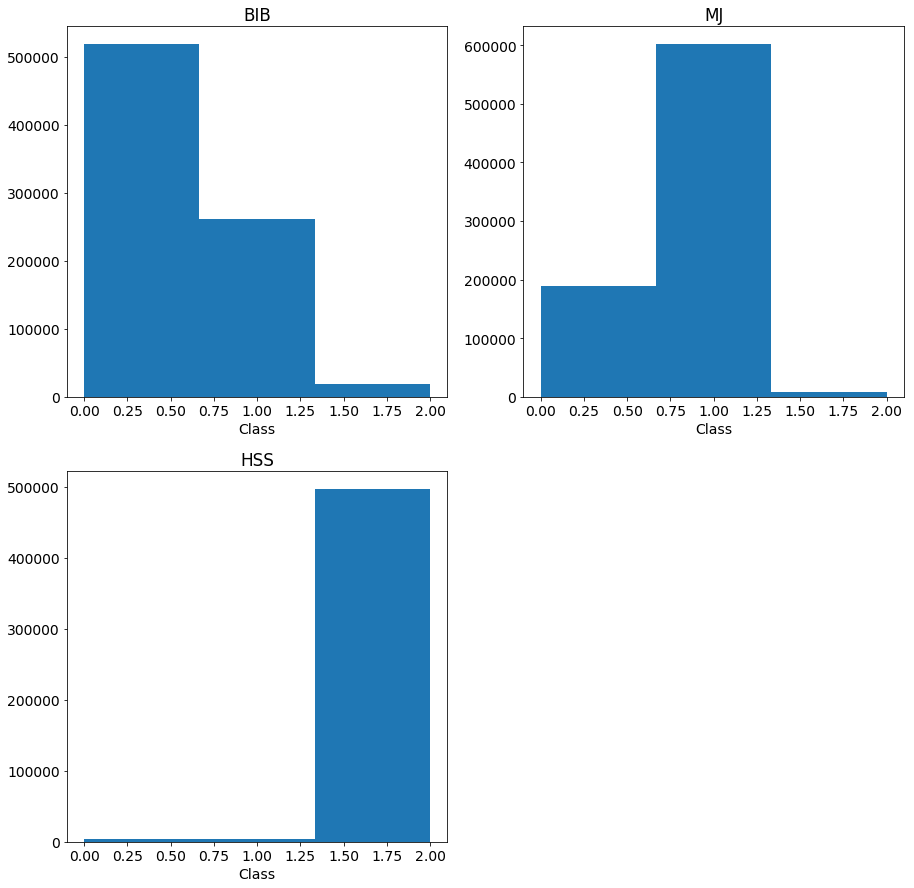

In [26]:
fig = plt.figure(figsize=(15,15))

ax = plt.subplot(221)
ax.hist(predicted_class[perf_events_class.Class == 0], bins=3)
ax.set_xlabel('Class')
ax.set_title('BIB')

ax = plt.subplot(222)
ax.hist(predicted_class[perf_events_class.Class == 1], bins=3)
ax.set_xlabel('Class')
ax.set_title('MJ')

ax = plt.subplot(223)
ax.hist(predicted_class[perf_events_class.Class == 2], bins=3)
ax.set_xlabel('Class')
ax.set_title('HSS')

In [28]:
predicted_prob = bdt1.predict_proba(perf_events)

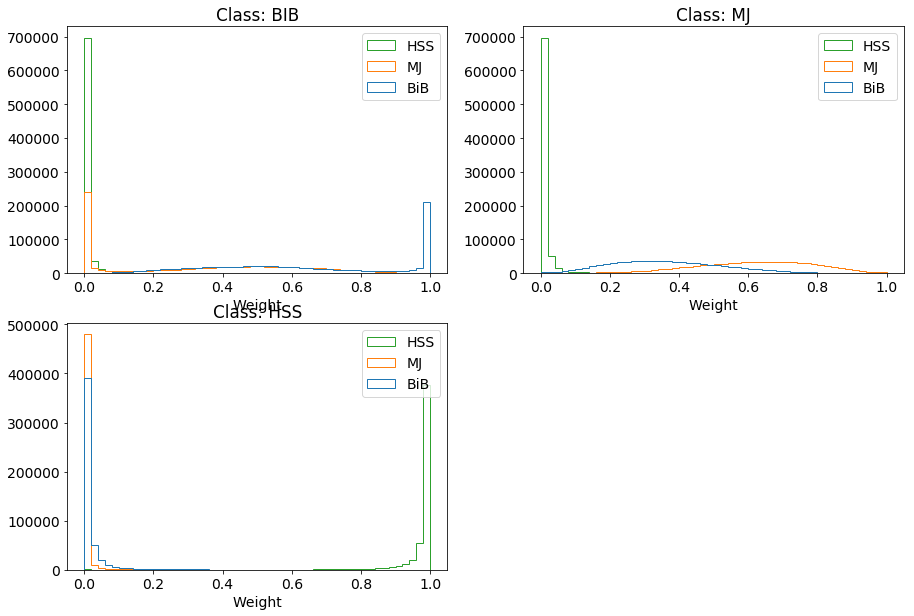

In [42]:
fig = plt.figure(figsize=(15,10))

ax = plt.subplot(221)
ax.hist(predicted_prob[perf_events_class.Class == 0], label=('BiB', "MJ", 'HSS'), bins=50, histtype = 'step')
ax.set_xlabel('Weight')
ax.set_title('Class: BIB')
ax.legend()

ax = plt.subplot(222)
ax.hist(predicted_prob[perf_events_class.Class == 1], label=('BiB', "MJ", 'HSS'), bins=50, histtype = 'step')
ax.set_xlabel('Weight')
ax.set_title('Class: MJ')
ax.legend()

ax = plt.subplot(223)
ax.hist(predicted_prob[perf_events_class.Class == 2], label=('BiB', "MJ", 'HSS'), bins=50, histtype = 'step')
ax.set_xlabel('Weight')
ax.set_title('Class: HSS')
ax.legend()

## TMVA Cross Check
We always have trouble with that. We need to look to see what we can expect with TMVA. Below there is Bib, MJ, and Signal, all three classes. 5 events are taken (first jet pt eta phi are shown along with event number so they can be correlated with the real full root trees). The full inputs are shown, in the proper order to be fed to the bdt. Then the result of the TMVA translation is evaluated, and then the probabilities from the sklean classifier are shown. A direct match isn't expected, but the trents (e.g. signal has the class2 column always larger than the bib or mj columns).

### What is wrong with this translation?
I'm using a slightly modified version of mlglue to do the translation. Yet, as you can see below, the MJ, Sig, and background come out almost alike. And the classifier works rather well when it is run internally. So... what is going on?

### BiB (class 0)
First lets look at BiB. We'll get some absolute numbers out of the weight calculations

In [57]:
events_25[0][:5][['RunNumber', 'EventNumber', 'JetPt', 'JetEta', 'JetPhi']]

,RunNumber,EventNumber,JetPt,JetEta,JetPhi
0,311170,927379924,191.9800,0.751230,1.51744
3,311170,929187568,155.0430,-0.640188,1.34265
4,311170,929187568,91.3555,0.247285,-2.10950
5,311170,929187568,41.3577,-0.138648,0.02486
9,311170,932610428,182.9320,-1.274750,1.42699


In [89]:
subsample = all_events[all_events_class.Class==0][:5]
subsample

,EnergyDensity,BIBDeltaTimingM,JetPt,HadronicLayer1Fraction,ShowerCenter,JetLat,FirstClusterRadius,JetLong,MaxTrackPt,PredictedLxy,BIBDeltaTimingP,PredictedLz,SumPtOfAllTracks
0,0.001389,15.063000,191.9800,0.745036,1784.0,0.859375,3376,0.953125,0.000000,2052.750,0.503155,1810.120,0.000000
1,0.001686,4.304950,155.0430,0.610702,916.0,0.964844,2656,0.660156,53.608300,719.184,13.267500,455.200,102.263000
2,0.005402,7.480070,91.3555,0.306610,218.0,0.867188,1840,0.695312,14.953600,741.596,2.930280,156.224,28.833500
3,0.002838,27.441500,41.3577,0.914956,310.0,0.910156,1832,0.894531,0.000000,1001.520,29.424500,346.007,0.000000
4,0.002960,-0.050031,182.9320,0.005701,2592.0,0.392578,5440,0.271484,0.423082,2646.290,30.758200,4184.980,0.423082


In [90]:
bdtGeneral.eval(subsample)

array([[0.34207481, 0.32719708, 0.33072811],
       [0.33981821, 0.33936401, 0.32081778],
       [0.34003145, 0.33785093, 0.32211763],
       [0.33805661, 0.33368641, 0.32825698],
       [0.35016682, 0.32668432, 0.32314886]])

In [91]:
bdt1.predict_proba(subsample)

array([[9.59878561e-01, 1.14691427e-02, 2.86522959e-02],
       [5.27753684e-01, 4.70789005e-01, 1.45731082e-03],
       [6.49440147e-01, 3.48036238e-01, 2.52361490e-03],
       [7.55547825e-01, 2.09725962e-01, 3.47262129e-02],
       [9.98732158e-01, 9.84602217e-04, 2.83239874e-04]])

### MultiJet (class 1)

Ok, now lets look at MJ, which is class 1. Note that the run number is not pulled correctly here. :(

In [80]:
events_25[1][:5][['RunNumber', 'EventNumber', 'JetPt', 'JetEta', 'JetPhi']]

,RunNumber,EventNumber,JetPt,JetEta,JetPhi
1,284500,4160,58.6659,0.915437,0.622971
3,284500,4144,143.7050,0.985570,-1.977800
4,284500,4144,53.9551,-1.521310,-2.185010
5,284500,4144,49.4316,0.858851,-1.415250
6,284500,4072,85.1043,0.613642,2.203130


In [92]:
subsample = all_events[all_events_class.Class==1][:5]
subsample

,EnergyDensity,BIBDeltaTimingM,JetPt,HadronicLayer1Fraction,ShowerCenter,JetLat,FirstClusterRadius,JetLong,MaxTrackPt,PredictedLxy,BIBDeltaTimingP,PredictedLz,SumPtOfAllTracks
133694,0.003311,14.31030,58.6659,0.570251,362.0,0.933594,2512,0.988281,2.38707,675.068,2.18954,577.785,3.81886
133695,0.004364,14.50810,143.7050,0.533774,251.0,0.886719,2512,0.917969,32.18010,655.481,1.97326,741.678,85.33030
133696,0.011231,1.26047,53.9551,0.213439,50.0,0.648438,3312,0.320312,3.21193,458.212,21.01740,938.516,3.21193
133697,0.006104,14.42450,49.4316,0.814982,246.0,0.519531,2432,0.718750,7.72666,698.374,2.70632,596.755,7.72666
133698,0.000149,17.00240,85.1043,0.374585,1608.0,0.835938,3296,0.664062,24.43720,1064.960,5.30982,662.527,49.71430


In [93]:
bdtGeneral.eval(subsample)

array([[0.33474463, 0.33581647, 0.32943889],
       [0.3382659 , 0.34168465, 0.32004945],
       [0.33506811, 0.3371751 , 0.32775679],
       [0.33511847, 0.33714463, 0.3277369 ],
       [0.33797426, 0.33891934, 0.3231064 ]])

In [94]:
bdt1.predict_proba(subsample)

array([[0.38758609, 0.54411158, 0.06830233],
       [0.26379036, 0.73530373, 0.00090592],
       [0.33283115, 0.63525153, 0.03191732],
       [0.33816484, 0.63008337, 0.03175179],
       [0.42410826, 0.57178391, 0.00410783]])

### Signal (class 2)

Finally, lets look at signal

In [84]:
events_25[2][:5][['RunNumber', 'EventNumber', 'JetPt', 'JetEta', 'JetPhi']]

,RunNumber,EventNumber,JetPt,JetEta,JetPhi
2,284500,11752,208.314,0.965120,1.787220
9,284500,11784,360.325,0.599033,3.006070
25,284500,11564,350.417,-0.457128,-2.612860
27,284500,11508,191.903,1.241270,2.207490
29,284500,11092,502.285,0.030178,-0.760794


In [86]:
subsample = all_events[all_events_class.Class==2][:5]
subsample

,EnergyDensity,BIBDeltaTimingM,JetPt,HadronicLayer1Fraction,ShowerCenter,JetLat,FirstClusterRadius,JetLong,MaxTrackPt,PredictedLxy,BIBDeltaTimingP,PredictedLz,SumPtOfAllTracks
267306,0.000660,36.55420,208.314,-0.001131,3936.0,0.371094,5440,0.322266,0.00000,3293.99,8.81774,3404.0600,0.00000
267307,0.043213,7.72208,350.417,0.784341,296.0,0.691406,1952,0.449219,1.07012,1657.43,13.22330,910.3080,1.07012
267308,0.016479,10.67530,502.285,0.492913,780.0,0.953125,2272,0.531250,0.00000,1278.63,9.89789,86.4325,0.00000
267309,0.013611,31.38300,258.119,0.722778,772.0,0.941406,4640,0.800781,0.00000,1335.53,1.65931,3660.3500,0.00000
267310,0.001190,10.04690,287.651,0.023426,2720.0,0.890625,5568,0.945312,0.00000,2696.14,41.47700,4180.5300,0.00000


In [87]:
bdtGeneral.eval(subsample)

array([[0.33087839, 0.323093  , 0.3460286 ],
       [0.32639066, 0.32112945, 0.35247989],
       [0.32355035, 0.32350206, 0.35294758],
       [0.32796696, 0.32344575, 0.34858729],
       [0.32808424, 0.32095073, 0.35096503]])

In [88]:
bdt1.predict_proba(subsample)

array([[1.28688380e-02, 1.21321028e-03, 9.85917952e-01],
       [5.24954057e-04, 1.05401145e-04, 9.99369645e-01],
       [1.91891967e-04, 1.92777657e-04, 9.99615330e-01],
       [2.57339961e-03, 6.54826390e-04, 9.96771774e-01],
       [1.35380007e-03, 1.53227389e-04, 9.98492973e-01]])

## Plots of TMVA Translation Performance

In [95]:
%%time
predicted_tmva_weights = bdtGeneral.eval(perf_events)

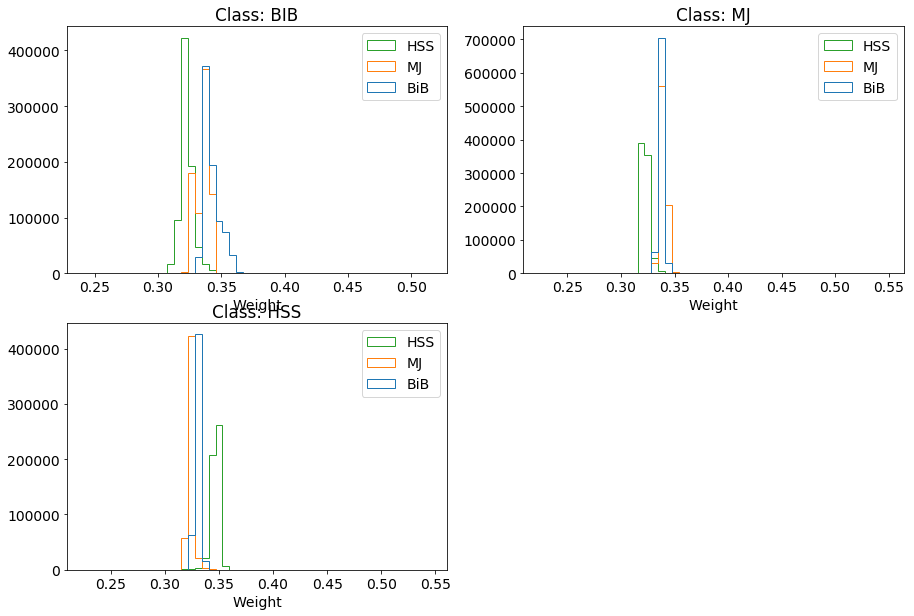

In [96]:
fig = plt.figure(figsize=(15,10))

ax = plt.subplot(221)
ax.hist(predicted_tmva_weights[perf_events_class.Class == 0], label=('BiB', "MJ", 'HSS'), bins=50, histtype = 'step')
ax.set_xlabel('Weight')
ax.set_title('Class: BIB')
ax.legend()

ax = plt.subplot(222)
ax.hist(predicted_tmva_weights[perf_events_class.Class == 1], label=('BiB', "MJ", 'HSS'), bins=50, histtype = 'step')
ax.set_xlabel('Weight')
ax.set_title('Class: MJ')
ax.legend()

ax = plt.subplot(223)
ax.hist(predicted_tmva_weights[perf_events_class.Class == 2], label=('BiB', "MJ", 'HSS'), bins=50, histtype = 'step')
ax.set_xlabel('Weight')
ax.set_title('Class: HSS')
ax.legend()

Note in this version how everything is on top of itself. :(